# Visualising the correlation between rainfall, surface water extent, and discharge

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.frequencies import to_offset

## Analysis parameters

In [2]:
okavango_rainfall='results/okavango_rainfall_2013-12_to_2021-05-31.csv'
upstream_rainfall='results/upstream_rainfall_2013-12_to_2021-05-31.csv'
upstream_rainfall_1W='results/upstream_rainfall_1W_2013-12_to_2021-05-31.csv'
water_extent='results/water_extent_2013-12_to_2021-05.csv'
discharge = 'data/mohembo_daily_water_discharge_data.csv'

## Read files

In [3]:
df=pd.read_csv(okavango_rainfall, index_col='time', parse_dates=True)[0:-1]
upr=pd.read_csv(upstream_rainfall, index_col='time',parse_dates=True)[0:-1]
upr_1W=pd.read_csv(upstream_rainfall_1W, index_col='time',parse_dates=True)
we=pd.read_csv(water_extent, index_col='time',parse_dates=True)
dis=pd.read_csv(discharge)

## Process discharge data

In [4]:
dis['date'] = pd.to_datetime(dis['date'], dayfirst=True)
dis = dis.set_index('date')

### Plot the raw data

Note the data density of discharge measurements declines in the later years

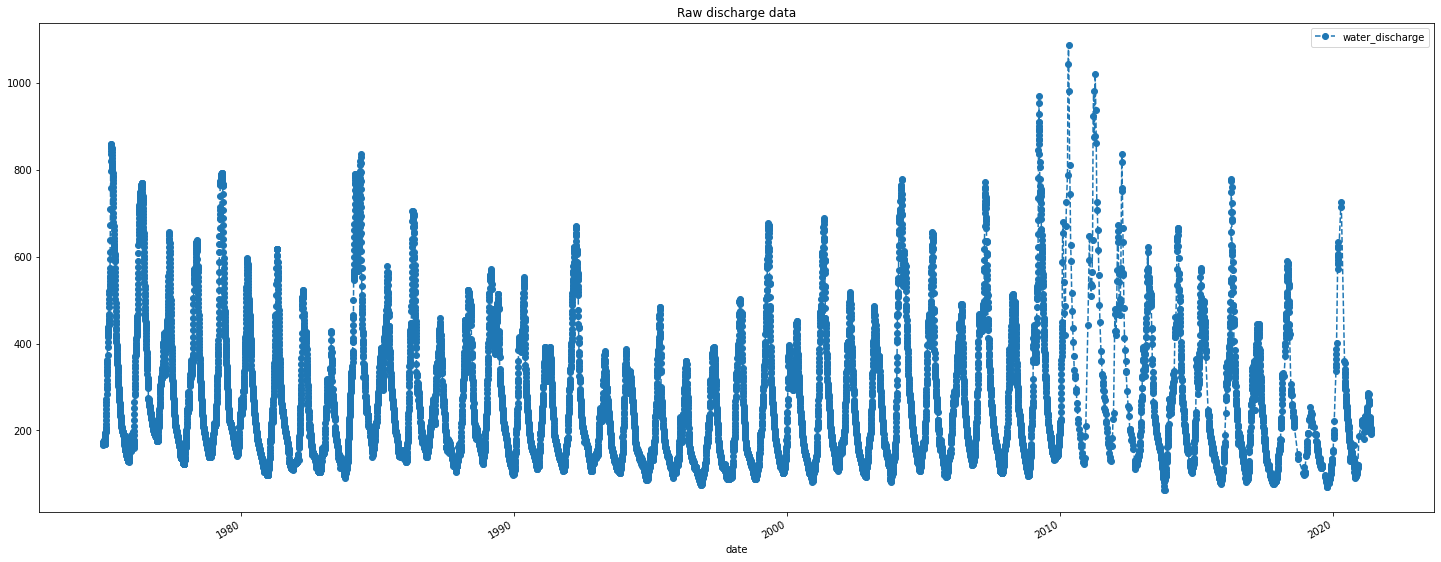

In [5]:
dis.plot(figsize=(25,10),  marker='o', linestyle='dashed')
plt.title('Raw discharge data');

### Plot the number of observations per year

As this is daily data, the maximum number of observations per year should be 365. Note the big decline in data density from 2010 onwards. 
**The discharge data is therefore largely unreliable from 2010 onwards**

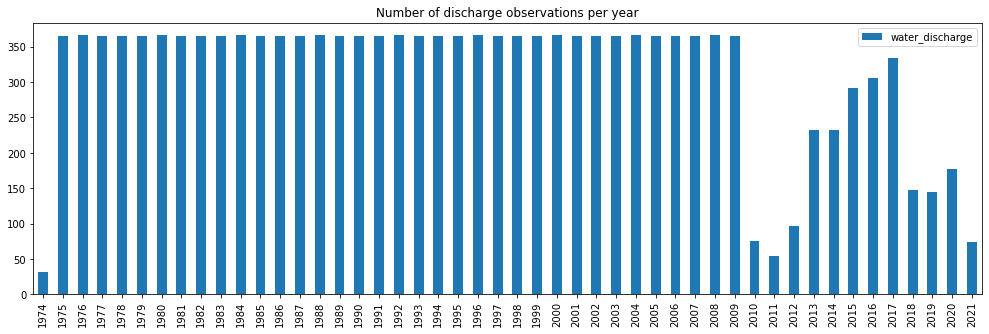

In [6]:
dis.groupby(dis.index.year).count().plot.bar(figsize=(17,5))
plt.title('Number of discharge observations per year')
plt.xlabel('');

### Try gapfilling the discharge data

First resample the dataset to weekly means to create evenly spaced measurements, and then do a simple linear interpolation between points to gapfill weeks where there is no discharge data.

In [7]:
dis = dis.resample('W').mean().interpolate(limit=2)

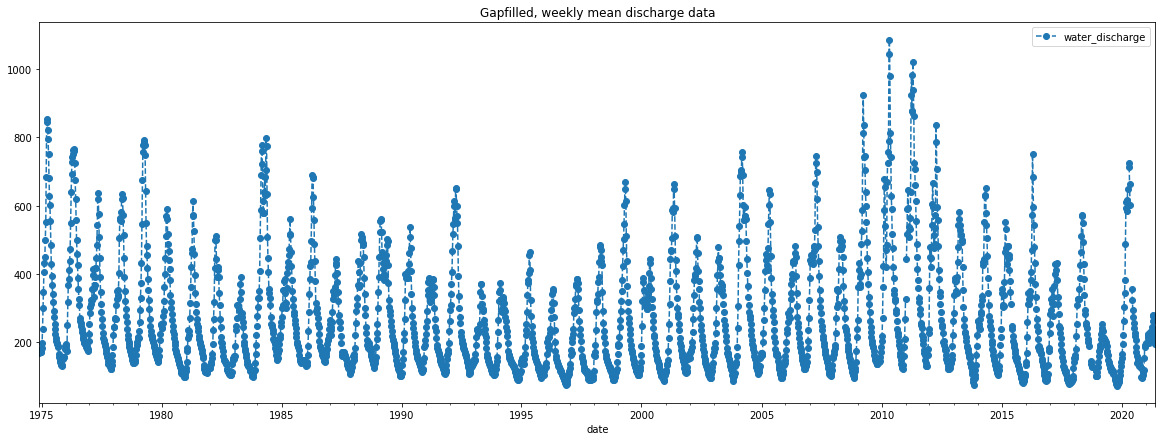

In [8]:
dis.plot(figsize=(20,7),  marker='o', linestyle='dashed')
plt.title('Gapfilled, weekly mean discharge data');

### Plot weekly upstream rainfall alongside weekly discharge

This will help highlight if the discharge data is reliable - if there are large gaps in the discharge data then, for example, the seasonal peak flow event might not be recorded.  Where there is significant volumes of rainfall but a correspsonding peak in discharge is absent, this may indicate the discharge data simply missed recording peak flow. 

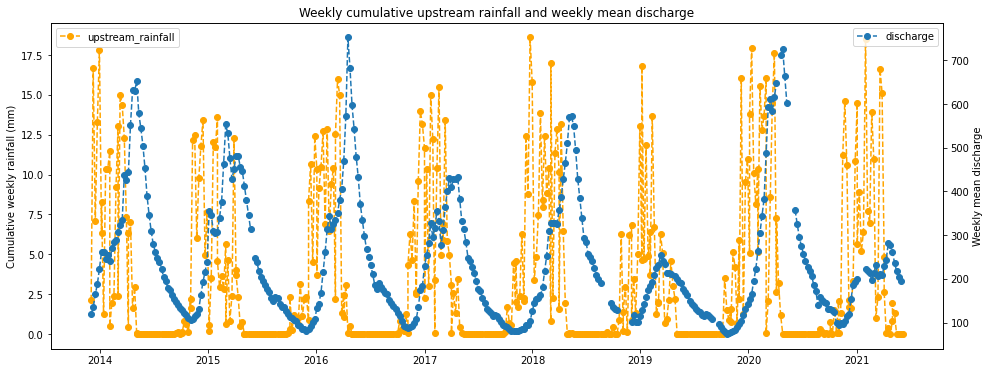

In [9]:
fig, ax1 = plt.subplots(1,1, figsize=(16,6))
ax2 = ax1.twinx()
ax1.plot(upr_1W['cumulative 1-week rainfall (mm)'], label='upstream_rainfall', marker='o', linestyle='dashed', c='orange')
ax2.plot(dis[dis.index >= pd.to_datetime('2013-12-01')],label='discharge', marker='o', linestyle='dashed')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel('Cumulative weekly rainfall (mm)')
ax2.set_ylabel('Weekly mean discharge')
plt.title('Weekly cumulative upstream rainfall and weekly mean discharge');

### Resample discharge dataset to seasonal means

This will match the datasets we collected from ERA5 and Landsat 

In [10]:
dis = dis.resample('QS-DEC').mean()
dis.index = dis.index + to_offset("1M")
dis = dis[dis.index >= pd.to_datetime('2013-12-31')]

### Merge into one dataframe

And expprt results as csv

In [11]:
df['upstream_rain']=upr
df['water_extent']=we
df['discharge']=dis
df = df.rename({'cumulative 3-month rainfall (mm)':'okavango_rain'},axis=1)
df.to_csv('results/okavango_all_datasets.csv')

## Plot all seasonal datasets together

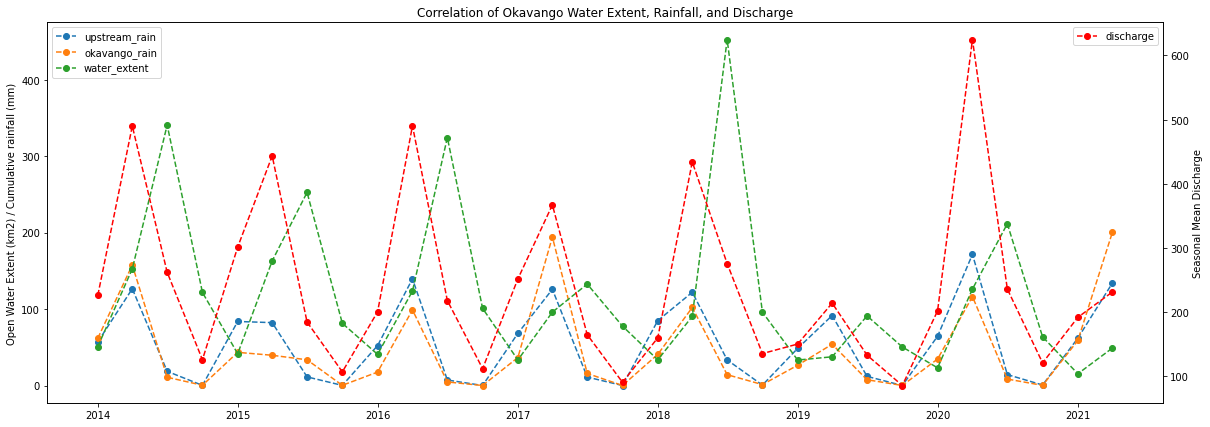

In [12]:
#set figure
fig, ax1 = plt.subplots(figsize=(20,7))
ax2 = ax1.twinx()
#add plots
ax1.plot(df['upstream_rain'], label = 'upstream_rain', linestyle='dashed', marker='o')
ax1.plot(df['okavango_rain'], label = 'okavango_rain', linestyle='dashed', marker='o')
ax1.plot(df['water_extent'], label = 'water_extent', linestyle='dashed', marker='o')
ax2.plot(df['discharge'], label='discharge', linestyle='dashed', marker='o', color='red')
#tidy up figure
ax1.set_ylabel('Open Water Extent (km2) / Cumulative rainfall (mm)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('Seasonal Mean Discharge')
plt.title('Correlation of Okavango Water Extent, Rainfall, and Discharge')
plt.savefig(f'results/Rainfall_water_extent_and_discharge.png');